In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Build model

def build_model_deeper(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block_cSE(conv1,start_neurons * 1)
    conv1 = residual_block_cSE(conv1,start_neurons * 1)
    conv1 = residual_block_cSE(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block_cSE(conv2,start_neurons * 2)
    conv2 = residual_block_cSE(conv2,start_neurons * 2)
    conv2 = residual_block_cSE(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block_cSE(conv3,start_neurons * 4)
    conv3 = residual_block_cSE(conv3,start_neurons * 4)
    conv3 = residual_block_cSE(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block_cSE(conv4,start_neurons * 8)
    conv4 = residual_block_cSE(conv4,start_neurons * 8)
    conv4 = residual_block_cSE(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block_cSE(convm,start_neurons * 16)
    convm = residual_block_cSE(convm,start_neurons * 16)
    convm = residual_block_cSE(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [3]:


# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [5]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
train_df.index.values,
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.coverage.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
np.random.choice(5,5, replace=False)

array([3, 0, 2, 4, 1])

In [7]:
aug_img = []
aug_msk = []
augments = [
    (1.0, HorizontalFlip(p=1)),
#     (0.35, VerticalFlip(p=1)),
#     (0.35, RandomRotate90(p=1)),
#     (0.35, Transpose(p=1)),
    (0.2, ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)),
    (0.2, GridDistortion(p=1)),
    (0.1, OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)),
#     (0.1, RandomSizedCrop(p=1, min_max_height=(int(img_size_ori / 2), img_size_ori), height=img_size_ori, width=img_size_ori)),
]

for ratio, aug in tqdm_notebook(augments):
    selidx = np.random.choice(x_train.shape[0], int(x_train.shape[0] * ratio), replace=False)
    for idx in tqdm_notebook(selidx):
        augmented = aug(image=x_train[idx], mask=y_train[idx])
        aimg = augmented['image']
        amsk = augmented['mask']
        if len(aimg.shape) < 3:
            aimg = aimg[...,np.newaxis]
        if len(amsk.shape) < 3:
            amsk = amsk[...,np.newaxis]
        aug_img.append(aimg)
        aug_msk.append(amsk)

aug_img = np.asarray(aug_img)
aug_msk = np.asarray(aug_msk)
x_train = np.append(x_train, aug_img, axis=0)
y_train = np.append(y_train, aug_msk, axis=0)

In [8]:

print(x_train.shape)
print(y_valid.shape)

(8000, 101, 101, 1)
(800, 101, 101, 1)


In [9]:
start_feature = 16
batch_size = 32
dropout = 0.5
base_name = 'Unet_resnet_deeper_cse_aug3_{}_{}'.format(batch_size, dropout)
basic_name = '../model/{}'.format(base_name)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model_deeper(input_layer, start_feature,dropout)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

board = keras.callbacks.TensorBoard(log_dir='log/{}'.format(base_name),
                       histogram_freq=0, write_graph=True, write_images=False)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 200

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)

../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
../model/Unet_resnet_deeper_cse_aug3_32_0.5.csv
Train on 8000 samples, validate on 800 samples
Epoch 1/200
8000/8000 [==============================] - 58s 7ms/step - loss: 0.4093 - my_iou_metric: 0.4211 - val_loss: 8.2340 - val_my_iou_metric: 0.1491

Epoch 00001: val_my_iou_metric improved from -inf to 0.14913, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
Epoch 2/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.3201 - my_iou_metric: 0.5333 - val_loss: 0.7158 - val_my_iou_metric: 0.3875

Epoch 00002: val_my_iou_metric improved from 0.14913 to 0.38750, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
Epoch 3/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.2960 - my_iou_metric: 0.5528 - val_loss: 0.7908 - val_my_iou_metric: 0.4886

Epoch 00003: val_my_iou_metric improved from 0.38750 to 0.48862, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.


Epoch 00032: val_my_iou_metric did not improve from 0.75762
Epoch 33/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.0991 - my_iou_metric: 0.7544 - val_loss: 0.1639 - val_my_iou_metric: 0.7570

Epoch 00033: val_my_iou_metric did not improve from 0.75762

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 34/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.0953 - my_iou_metric: 0.7574 - val_loss: 0.1570 - val_my_iou_metric: 0.7548

Epoch 00034: val_my_iou_metric did not improve from 0.75762
Epoch 35/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.0947 - my_iou_metric: 0.7614 - val_loss: 0.1509 - val_my_iou_metric: 0.7606

Epoch 00035: val_my_iou_metric improved from 0.75762 to 0.76062, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
Epoch 36/200
8000/8000 [==============================] - 43s 5ms/step - loss: 0.0927 - my_iou_metric: 0.7627 - val_loss: 0.1640 - va

In [10]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=12, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)
epochs = 200

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 8000 samples, validate on 800 samples
Epoch 1/200
8000/8000 [==============================] - 102s 13ms/step - loss: 0.1058 - my_iou_metric_2: 0.7385 - val_loss: 1.4261 - val_my_iou_metric_2: 0.4559

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.45588, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
Epoch 2/200
8000/8000 [==============================] - 87s 11ms/step - loss: 0.1057 - my_iou_metric_2: 0.7314 - val_loss: 0.0616 - val_my_iou_metric_2: 0.7500

Epoch 00002: val_my_iou_metric_2 improved from 0.45588 to 0.75000, saving model to ../model/Unet_resnet_deeper_cse_aug3_32_0.5.model
Epoch 3/200
8000/8000 [==============================] - 87s 11ms/step - loss: 0.0393 - my_iou_metric_2: 0.7449 - val_loss: 0.1015 - val_my_iou_metric_2: 0.7411

Epoch 00003: val_my_iou_metric_2 did not improve from 0.75000
Epoch 4/200
8000/8000 [==============================] - 87s 11ms/step - loss: 0.0196 - my_iou_metric_2: 0.7477 - val_loss: 0.0463 - val_my_i

8000/8000 [==============================] - 87s 11ms/step - loss: -0.4117 - my_iou_metric_2: 0.8251 - val_loss: 0.0233 - val_my_iou_metric_2: 0.7806

Epoch 00033: val_my_iou_metric_2 did not improve from 0.78413

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 34/200
8000/8000 [==============================] - 88s 11ms/step - loss: -0.4151 - my_iou_metric_2: 0.8258 - val_loss: -0.0032 - val_my_iou_metric_2: 0.7826

Epoch 00034: val_my_iou_metric_2 did not improve from 0.78413
Epoch 35/200
8000/8000 [==============================] - 88s 11ms/step - loss: -0.4227 - my_iou_metric_2: 0.8275 - val_loss: -0.0012 - val_my_iou_metric_2: 0.7805

Epoch 00035: val_my_iou_metric_2 did not improve from 0.78413
Epoch 36/200
8000/8000 [==============================] - 87s 11ms/step - loss: -0.4184 - my_iou_metric_2: 0.8252 - val_loss: 0.0075 - val_my_iou_metric_2: 0.7785

Epoch 00036: val_my_iou_metric_2 did not improve from 0.78413

Epoch 00036: ReduceLROnPl

In [11]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})




[0.782    0.783    0.784375 0.785625 0.786125 0.78775  0.789875 0.79075
 0.791125 0.79125  0.791875 0.793625 0.794875 0.79575  0.794875 0.794625
 0.796875 0.797875 0.79725  0.79625  0.7955   0.795375 0.796    0.794875
 0.793875 0.79275  0.791375 0.79025  0.7895   0.788    0.787375]


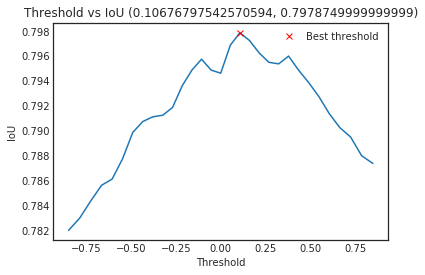

In [12]:
preds_valid = predict_result(model,x_valid,img_size_target)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [13]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [14]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/{}.csv'.format(base_name), 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")


Usedtime = 5.303412437438965 s
save result
upload result
cmd: kaggle competitions submit -c tgs-salt-identification-challenge -f ../result/Unet_resnet_deeper_cse_aug3_32_0.5.csv.7z -m "submit"
Kernel run time = 1.6863577647341623 hours
